# Deep Learning: Image Captioning

In [5]:
#!pip install multiprocess
#!pip install torchsummary

     |████████████████████████████████| 128 kB 2.1 MB/s eta 0:00:01


In [72]:
import sys
sys.path.append('..')
import os
import shutil
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import random
import seaborn as sns
import pandas as pd
import pickle

import program.model
import program.data

import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torchsummary import summary

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

# Data

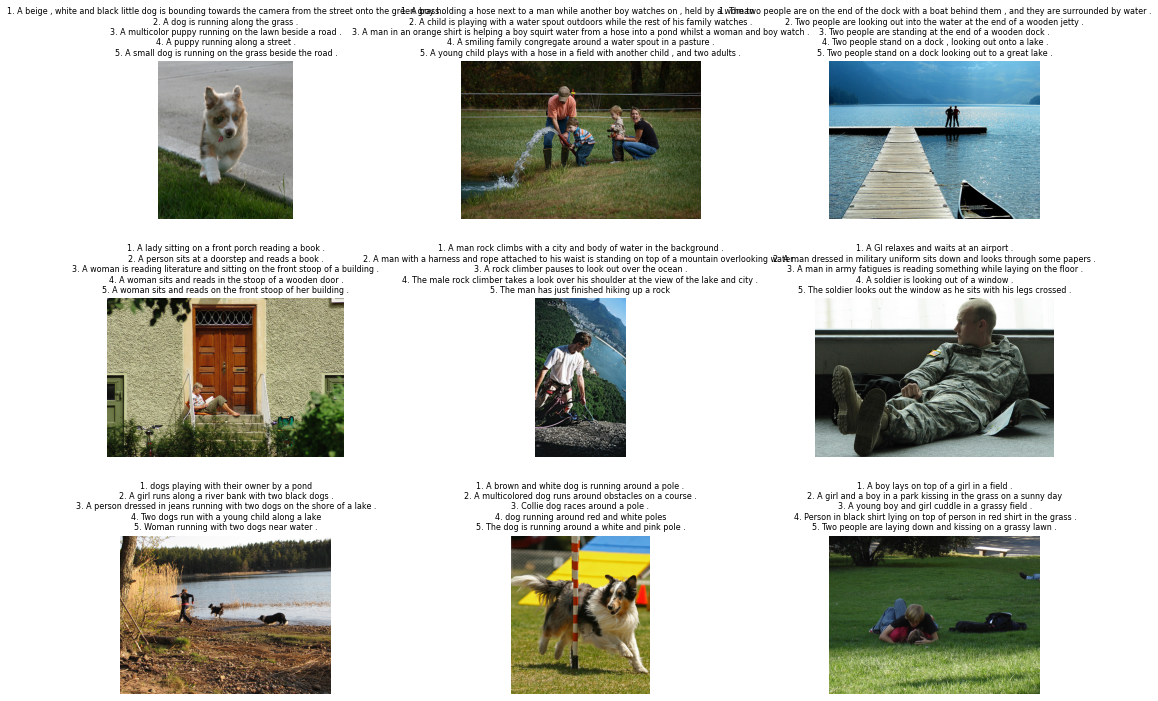

In [2]:
program.data.show_random_images(image_dir='./data/Images', captions_path='./data/captions.txt', count=9)

**Beschreibung:**

Das Bild zeigt einige Beispielbilder mit den dazugehörigen Captions. Pro Bild gibt es grundsätzlich 5 verschiedene Captions.

In [3]:
image_captions = pd.read_table('./data/captions.txt', sep=',')
image_captions.head(2)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .


Der Datensatz mit den Captions kann als CSV eingelesen werden. Pro Bild exisiteren mehrere Captions.

## Generate Train-Validate-Test

In [4]:
def generate_image_splits(image_folder, test_size=1000, validation_size=1000):
    images = np.array(os.listdir('./data/Images/'))
    np.random.shuffle(images)
    train_size = images.shape[0] - validation_size - test_size
    train_images = images[:train_size]
    assert len(train_images) == train_size
    images = images[train_size:]

    test_images = images[:test_size]
    assert len(test_images) == test_size
    images = images[test_size:]

    validation_images = images
    assert len(validation_images) == validation_size
    
    return (train_images, validation_images, test_images)

In [20]:
train_images, validation_images, test_images = generate_image_splits(image_folder='./data/Images/', 
                                                                     test_size=1000, validation_size=1000)

# prepare files to copy with multiprocessing
train_images = ['./data/Images/'+img for img in train_images]
train_images = [img + '__' + './data/train/' + img.split('/')[-1] for img in train_images]

validation_images = ['./data/Images/'+img for img in validation_images]
validation_images = [img + '__' + './data/val/' + img.split('/')[-1] for img in validation_images]

test_images = ['./data/Images/'+img for img in test_images]
test_images = [img + '__' + './data/test/' + img.split('/')[-1] for img in test_images]

In [31]:
# Check if works
function_check = False
if function_check:
    amount_test_images = 100
    test_img = train_images[:amount_test_images]
    program.data.copy_all_files(fp_from_to=test_img)

    for img in tqdm(test_img, desc='Deleting Images again'):
        assert os.path.isfile(img.split('__')[-1])
        os.remove(img.split('__')[-1])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 158.90it/s]


Deleting Images again:   0%|          | 0/100 [00:00<?, ?it/s]

In [32]:
copy_files = False
if copy_filesiles:
    program.data.copy_all_files(fp_from_to=train_images)
    program.data.copy_all_files(fp_from_to=validation_images)
    program.data.copy_all_files(fp_from_to=test_images)

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 66.91it/s]


## Load Images

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [ ]:
transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor()])
dataset = datasets.ImageNet(".", split="train", transform=transform)

means = []
stds = []
for img in subset(dataset):
    means.append(torch.mean(img))
    stds.append(torch.std(img))

mean = torch.mean(torch.tensor(means))
std = torch.mean(torch.tensor(stds))

## Dataloader

# Modeling

In [76]:
# Load CNN 
resnet = models.resnet50(pretrained=False)
summary(resnet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [37]:
class ImageEncoder(nn.Module):
    """Image Encoder with ResNet Architecture"""
    def __init__(self, embed_size, pretrained=False):
        super().__init__()
        self.is_pretrained = pretrained
        self.resnet = models.resnet50(pretrained=pretrained)
        self.resnet.fc = nn.Linear(in_features=2048, embed_size, bias=True)
        self.relu = nn.ReLU()
        
    def forward(x):
        if self.is_pretrained:
            self.resnet.fc.weights.requires_grad = True
            self.resnet.fc.bias.requires_grad = True
        x = self.resnet(x)
        x = self.relu(x)
        return x
    
class ImageCaptionDecoder(nn.Module):
    """"""
    def __init__(self, embed_size, vocab_size, hidden_state):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_size)
        self.lstm = nn.LSTM()
    
class EncoderDecoder(nn.Module):
    
    def __init__(self, embed_size, vocab_size, hidden_state, lstm_layers)
    super().__init__()
    
    self.encoder = ImageEncoder(embed_size=embed_size)
    self.decoder = ImageCaptionDecoder(embed_size=embed_size, vocab_size=vocab_size, 
                                       hidden_state=hidden_state, lstm_layers=lstm_layers)
    

# Sources

https://arxiv.org/pdf/1411.4555.pdf

https://www.kaggle.com/mdteach/image-captioning-with-out-attention-pytorchhttps://www.kaggle.com/mdteach/image-captioning-with-out-attention-pytorch